#  Atomistic Simulations with Machine Learning Interatomic Potentials

Author: Vignesh Sathyaseelan (vsathyas@purdue.edu)

This notebook demonstrates how to integrate a machine-learned interatomic potential (MLIP) with ASE for:
- Geometry optimizations
- Molecular dynamics (MD) simulations
- Nudged Elastic Band (NEB) calculations
- Adsorption Free Energy calculations


## 1. Setup & Imports

In [5]:
# Install the Atomic Simulation Environment (ASE)
# for atomistic simulations, geometry optimization, NEB, etc.
!pip install ase

# Install MACE (Machine-learning for Atomistic Computations) with PyTorch backend
# Provides ML interatomic potentials, compatible with ASE
!pip install mace-torch

# Install DFT-D3 (dispersion correction code)
# Useful for adding Grimme's D3 dispersion corrections to DFT/ML calculations
!pip install torch-dftd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.7/681.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 53.1 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=8a0046c66110ae21652f1faacc424f3f8bafd7fbdf95fff46e6f6bcdf7d501fd
  Stored in directory: /root/.cache/pip/wheels/1f/7d/e9/1ff2509f13767a55df12797

In [1]:
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

from ase import Atoms, units  # Import core ASE classes: Atoms for atomic structures, units for physical constants
from ase.io import read, write  # Import functions to read and write atomic structures
from ase.visualize import view  # Import function to interactively view structures
from ase.visualize.plot import plot_atoms  # Import function to plot atomic structures using Matplotlib

## 2. Geometry Optimization with EMT (Baseline)
We start by using the classical EMT potential for initial geometry optimization.
This provides a quick baseline before switching to more accurate MLIPs.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


      Step     Time          Energy          fmax
BFGS:    0 18:00:05        4.028091        8.048738
BFGS:    1 18:00:05        2.449931        3.186848
BFGS:    2 18:00:05        2.017079        1.749374
BFGS:    3 18:00:05        1.886456        0.998144
BFGS:    4 18:00:05        1.824383        1.013382
BFGS:    5 18:00:05        1.732153        1.237173
BFGS:    6 18:00:05        1.703410        0.277504


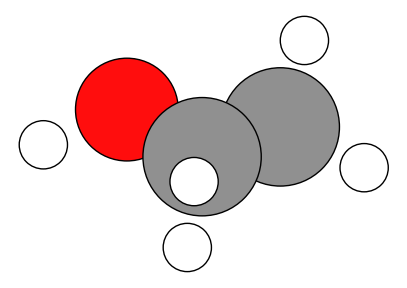

In [3]:
# Optimize with EMT
from ase.optimize import BFGS  # Import the BFGS optimizer from ASE
from ase.calculators.emt import EMT  # Import the EMT calculator (Effective Medium Theory)

# Read a structure and assign EMT calculator
atoms = read('/content/drive/MyDrive/Colab Notebooks/initial.xyz')  # Load the initial atomic structure from an XYZ file

atoms.calc = EMT()  # Set the EMT calculator for the atoms
opt = BFGS(atoms, trajectory='emt_opt.traj')  # Set up the BFGS optimizer and record the trajectory
opt.run(fmax=0.5)  # Run the optimization until the maximum force is below 0.5 eV/Å

write('/content/drive/MyDrive/Colab Notebooks/initial_optimized.xyz', atoms)  # Save the optimized structure to a new XYZ file
view(atoms)  # Optionally, open an interactive viewer to inspect the structure

fig, ax = plt.subplots(figsize=(5, 5))  # Create a matplotlib figure and axis
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))  # Plot the atoms with no rotation
ax.axis('off')  # Hide axis for better visualization
plt.show()  # Display the plot

## 3. Load MLIP Model into ASE

In [6]:
# Load your trained MLIP potential
import torch
import torch._dynamo
torch._dynamo.config.suppress_errors = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from mace.calculators import mace_mp

mlip_calc = mace_mp(model="medium-omat-0", dispersion=True, default_dtype="float64", device='cpu')


Using model under Academic Software License (ASL) license, see https://github.com/gabor1/ASL 
 To use this model you accept the terms of the license.
Using Materials Project MACE for MACECalculator with /root/.cache/mace/maceomat0mediummodel
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head default out of ['default']
Using TorchDFTD3Calculator for D3 dispersion corrections


## 4. Geometry Optimization with MLIP
Now we switch to a machine-learned interatomic potential (MLIP) for higher accuracy.

      Step     Time          Energy          fmax
BFGS:    0 18:01:14      -45.837428        1.064824
BFGS:    1 18:01:16      -45.859311        0.449681


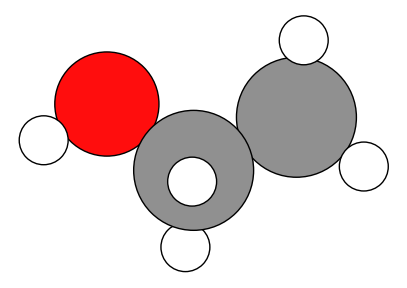

In [7]:
# Optimize with EMT
from ase.optimize import BFGS

# Read a structure and assign EMT calculator
atoms = read('/content/drive/MyDrive/Colab Notebooks/initial.xyz')

atoms.calc = mlip_calc
opt = BFGS(atoms, trajectory='emt_opt.traj')
opt.run(fmax=0.5)

write('/content/drive/MyDrive/Colab Notebooks/initial_optimized.xyz', atoms)
view(atoms)

fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))
ax.axis('off')
plt.show()


## 5. Molecular Dynamics (MD) Simulation Example

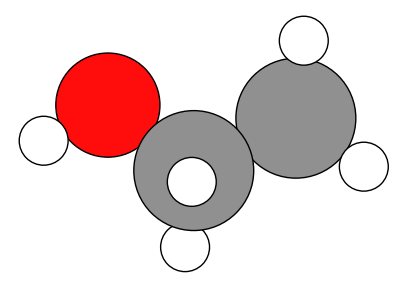

Cached MACE model to /root/.cache/mace/20231203mace128L1_epoch199model
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections


True

In [8]:
# Import necessary modules from ASE for molecular dynamics and plotting
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution  # For initializing velocities
from ase.md.langevin import Langevin  # Langevin thermostat for MD
from ase.md import MDLogger  # Logger for MD simulations

# Read the atomic structure from an XYZ file
atoms = read('/content/drive/MyDrive/Colab Notebooks/initial.xyz')
temp = 1000 #K  # Set the simulation temperature in Kelvin

# Visualize the structure
fig, ax = plt.subplots(figsize=(5, 5))  # Create a matplotlib figure and axis
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))  # Plot the atoms with no rotation
ax.axis('off')  # Hide axis for better visualization
plt.show()  # Display the plot
view(atoms)  # Optionally, open an interactive viewer

# Set up the calculator (potential) for the atoms
atoms.calc = mace_mp(model="medium", dispersion=True, default_dtype="float64", device='cpu')
MaxwellBoltzmannDistribution(atoms, temperature_K=temp)  # Initialize velocities according to the Maxwell-Boltzmann distribution

# Set up the Langevin dynamics
# 0.5 fs time step, target temperature, and friction coefficient
# Friction is set as 0.01 / fs
# units.fs is the femtosecond unit from ASE
# The Langevin thermostat keeps the system at the desired temperature

# Create the Langevin dynamics object
# To use VelocityVerlet instead of Langevin, uncomment the following line:
# from ase.md.verlet import VelocityVerlet
# from ase.md.verlet import VelocityVerlet
# dyn = VelocityVerlet(atoms, 0.5 * units.fs)
dyn = Langevin(atoms, 0.5 * units.fs, temperature_K=temp, friction=0.01 / units.fs)
# Attach a function to write the trajectory to an XYZ file every step
dyn.attach(lambda: write('md.xyz', atoms.copy(), append=True), interval=1)
# Attach a logger to record MD information every step
dyn.attach(MDLogger(dyn, atoms, "md.log"), interval=1)
# Run the MD simulation for 10 steps
dyn.run(2)

## 6. Setting up NEB Calculations.

      Step     Time          Energy          fmax
BFGS:    0 18:01:27      -45.837428        1.064824
BFGS:    1 18:01:28      -45.859311        0.449681
Potential ENergy: -45.85931096875373


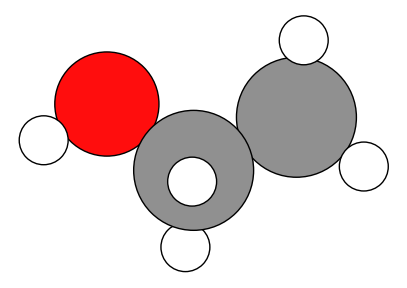

      Step     Time          Energy          fmax
BFGS:    0 18:01:28      -44.465455        1.066992
BFGS:    1 18:01:29      -44.485385        0.574978
BFGS:    2 18:01:30      -44.505966        0.419301
Potential ENergy: -44.50596581892575


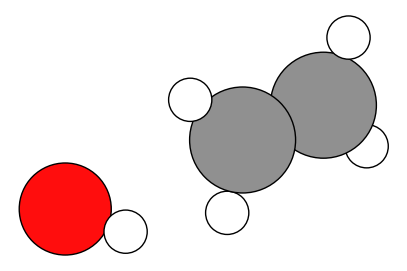

In [9]:
# Read initial structure
atoms = read('/content/drive/MyDrive/Colab Notebooks/initial.xyz')  # Load the initial atomic structure from an XYZ file
atoms.calc = mlip_calc  # Set the machine learning interatomic potential calculator

# Run a BFGS optimization
opt = BFGS(atoms, trajectory='opt.traj')  # Set up the BFGS optimizer and record the trajectory
opt.run(fmax=0.5)  # Run the optimization until the maximum force is below 0.5 eV/Å

# Save and view the optimized structure
write('/content/drive/MyDrive/Colab Notebooks/initial_optimized.xyz', atoms)  # Save the optimized structure to a new XYZ file

# Calculate the potential energy of the optimized structure
print(f"Potential ENergy: {atoms.get_potential_energy()}")  # Print the potential energy

# Visualize the optimized structure
fig, ax = plt.subplots(figsize=(5, 5))  # Create a matplotlib figure and axis
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))  # Plot the atoms with no rotation
ax.axis('off')  # Hide axis for better visualization
plt.show()  # Display the plot

# Read final structure
atoms = read('/content/drive/MyDrive/Colab Notebooks/final.xyz')  # Load the final atomic structure from an XYZ file
atoms.calc = mlip_calc  # Set the machine learning interatomic potential calculator

# Run a BFGS optimization
opt = BFGS(atoms, trajectory='opt.traj')  # Set up the BFGS optimizer and record the trajectory
opt.run(fmax=0.5)  # Run the optimization until the maximum force is below 0.5 eV/Å

# Save and view the optimized structure
write('/content/drive/MyDrive/Colab Notebooks/final_optimized.xyz', atoms)  # Save the optimized structure to a new XYZ file

# Calculate the potential energy of the optimized structure
print(f"Potential ENergy: {atoms.get_potential_energy()}")  # Print the potential energy

# Visualize the optimized structure
fig, ax = plt.subplots(figsize=(5, 5))  # Create a matplotlib figure and axis
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))  # Plot the atoms with no rotation
ax.axis('off')  # Hide axis for better visualization
plt.show()  # Display the plot

## 7. Nudged Elastic Band (NEB) Calculation

Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


      Step     Time          Energy          fmax
BFGS:    0 18:02:42      -39.759992        6.432953
BFGS:    1 18:02:47      -40.549108        5.361425
BFGS:    2 18:02:51      -41.771115       11.418172
BFGS:    3 18:02:54      -42.076651        3.162252
BFGS:    4 18:02:58      -42.669318        2.793089
BFGS:    5 18:03:01      -43.270143        3.797737
BFGS:    6 18:03:04      -43.505856        3.001349
BFGS:    7 18:03:07      -43.829564        1.676540
BFGS:    8 18:03:11      -43.979106        1.290754
BFGS:    9 18:03:14      -44.078850        1.743827
BFGS:   10 18:03:17      -44.096101        1.353902
BFGS:   11 18:03:20      -44.122287        0.922879
BFGS:   12 18:03:23      -44.121784        0.869222
BFGS:   13 18:03:27      -44.127697        1.161469
BFGS:   14 18:03:30      -44.141192        1.332388
BFGS:   15 18:03:33      -44.190436        0.817205
BFGS:   16 18:03:36      -44.240157        0.665440
BFGS:   17 18:03:40      -44.281502        0.480759
Forward barrie

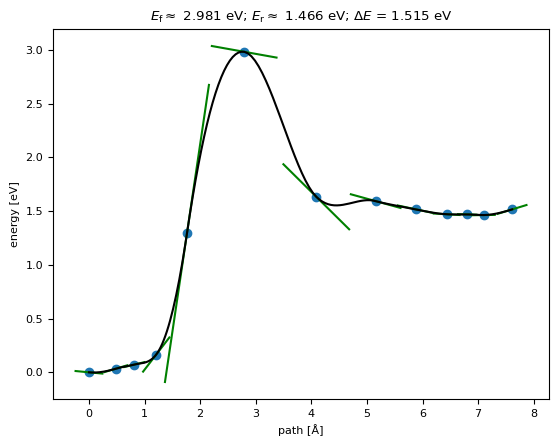

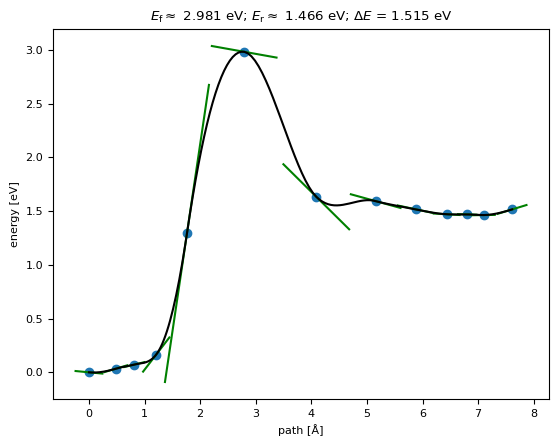

In [12]:
from ase.mep import NEB

# Load initial and final states
initial = read('/content/drive/MyDrive/Colab Notebooks/initial_optimized.xyz')  # Read the optimized initial structure
final = read('/content/drive/MyDrive/Colab Notebooks/final_optimized.xyz')      # Read the optimized final structure

# Create intermediate images for the NEB path
images = [initial]  # Start the images list with the initial structure
n_images = 11       # Number of intermediate images (not counting initial and final)
for i in range(n_images):
    img = initial.copy()  # Create a copy for each intermediate image
    images.append(img)
images.append(final)  # Add the final structure as the last image

# Set up the NEB (Nudged Elastic Band) object
neb = NEB(images, climb=True)  # Create NEB object; 'climb=True' enables the climbing image for better saddle point location
neb.interpolate(method='idpp')  # Interpolate images using the IDPP method for a more realistic initial path

# Save NEB images before optimization (for visualization or debugging)
for idx, img in enumerate(images):
    write(f'neb_image_{idx}.xyz', img)  # Save each image to an XYZ file

# Assign a calculator to each image (required for energy and force calculations)
for img in images:
    img.calc = mace_mp(model="medium", dispersion=True, default_dtype="float64", device='cpu')  # Replace with your MLIP calculator

# Optimize the NEB path using the BFGS optimizer
optimizer = BFGS(neb)  # Set up the BFGS optimizer for the NEB object
optimizer.run(fmax=0.5)  # Run the optimization until the maximum force is below 0.5 eV/Å

from ase.mep import NEBTools

# Initialize NEBTools with your images
nebtools = NEBTools(images)

# Get barrier and energy info
Ef, dE = nebtools.get_barrier()

print(f"Forward barrier: {Ef:.3f} eV")
print(f"Reverse barrier: {dE:.3f} eV")

# Optional: plot the energy profile using NEBTools (alternative to your custom plot)
nebtools.plot_band()